In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import networkx as nx
from scipy.optimize import least_squares

plt.style.use(["science","bright","grid"])
import sys
sys.path.append("../src/")
import nanonets

In [8]:
N_x, N_y, N_z       = 3,3,1
electrode_pos       = [[0,0,0],[2,0,0],[0,2,0],[2,2,0]]
radius, radius_std  = 10.0, 0.0
eps_r, eps_s        = 2.6, 3.9
np_distance         = 1
voltage_values      = [0.8,0.0,0.0,0.0,0.0]
electrode_type      = ["constant"]*4

In [2]:
topology = {
    "Nx"                : 3,
    "Ny"                : 3,
    "Nz"                : 1,
    'e_pos'             : [[0,0,0],[2,0,0],[0,2,0],[2,2,0]],
    "electrode_type"    : ["constant"]*4
}
sim_class   = nanonets.simulation(topology)
radii       = np.array([10., 5., 10., 20., 10., 30., 10., 20., 10.])
adj_array   = sim_class.net_topology.copy()
print(adj_array)

[[   1    1    3 -100 -100 -100]
 [-100    0    2    4 -100 -100]
 [   2    1    5 -100 -100 -100]
 [-100    0    4    6 -100 -100]
 [-100    1    3    5    7 -100]
 [-100    2    4    8 -100 -100]
 [   3    3    7 -100 -100 -100]
 [-100    4    6    8 -100 -100]
 [   4    5    7 -100 -100 -100]]


`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 1.2375e+03, final cost 1.0730e-13, first-order optimality 3.32e-06.


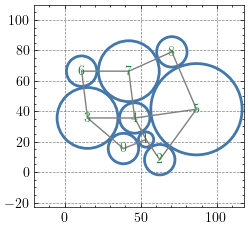

In [ ]:
def _seg_seg_dist(p1, p2, q1, q2):
    """
    Compute shortest distance between segments p1–p2 and q1–q2 in 2D.
    """
    u = p2 - p1
    v = q2 - q1
    w = p1 - q1
    a = u.dot(u); b = u.dot(v); c = v.dot(v)
    d = u.dot(w); e = v.dot(w)
    D = a*c - b*b
    if D < 1e-8:  # nearly parallel
        s = 0.0
        t = e / c if c > 1e-8 else 0.0
    else:
        s = ( b*e - c*d) / D
        t = ( a*e - b*d) / D
    s = np.clip(s, 0.0, 1.0)
    t = np.clip(t, 0.0, 1.0)
    cp1 = p1 + s*u
    cp2 = q1 + t*v
    return np.linalg.norm(cp1 - cp2)

def pack_down_pull_min_all(adj_array, radii, w_neigh=1.0, w_minsep=10.0, w_planar=1e5, margin=0.0):
    
    adj   = np.asarray(adj_array)
    radii = np.asarray(radii)
    N     = len(radii)

    # build neighbor list & undirected edges
    neigh_lists = [np.unique(adj[i][adj[i]>=0].astype(int)) for i in range(N)]
    edges       = [(i, j) for i in range(N) for j in neigh_lists[i] if j > i]

    # compute uniform grid spacing D
    min_neigh = np.array([radii[i] + radii[j] + 1 for i, j in edges])
    D = min_neigh.max()

    # initial grid layout (N must be a perfect square)
    L = int(np.round(np.sqrt(N)))
    if L * L != N:
        raise ValueError("N is not a perfect square; provide custom init coords")
    grid_xy = np.column_stack((np.arange(N) % L, np.arange(N) // L))
    x0 = (grid_xy * D).ravel()

    # all pairs for global minimum separation
    all_pairs = [(i, j) for i in range(N) for j in range(i+1, N)]

    # edge-pairs for planarity test
    edge_pairs = []
    for a, b in edges:
        for c, d in edges:
            if a < b and c < d and {a, b}.isdisjoint({c, d}):
                if (c, d, a, b) not in edge_pairs:
                    edge_pairs.append((a, b, c, d))

    # precompute minimum center distances
    min_all = { (i, j): radii[i] + radii[j] + 1 for (i, j) in all_pairs }

    def residuals(x):
        X = x.reshape(N, 2)
        res = []

        # 1) neighbor-spring: drive d -> min_all
        for (i, j) in edges:
            d = np.linalg.norm(X[i] - X[j])
            res.append(w_neigh * (d - min_all[(i, j)]))

        # 2) global min-separation hinge
        for (i, j) in all_pairs:
            d = np.linalg.norm(X[i] - X[j])
            pen = max(0.0, min_all[(i, j)] - d)
            res.append(w_minsep * pen)

        # 3) planarity hinge
        for (i, j, k, l) in edge_pairs:
            dseg = _seg_seg_dist(X[i], X[j], X[k], X[l])
            pen = max(0.0, margin - dseg)
            res.append(w_planar * pen)

        return np.array(res)

    sol = least_squares(residuals, x0, method='trf', verbose=1)
    return sol.x.reshape(N, 2)

def plot_circles(coords, radii, adj_array):
    """Draw circles and edges using NetworkX + Matplotlib."""
    N = len(radii)
    G = nx.Graph()
    G.add_nodes_from(range(N))
    adj = np.asarray(adj_array)
    for i in range(N):
        for j in adj[i][adj[i] >= 0].astype(int):
            if i < j:
                G.add_edge(i, j)

    pos = {i: tuple(coords[i]) for i in range(N)}
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # draw edges
    for u, v in G.edges():
        x0, y0 = coords[u]
        x1, y1 = coords[v]
        ax.plot([x0, x1], [y0, y1], 'gray', lw=1)

    # draw circles and labels
    for i in range(N):
        circ = plt.Circle(pos[i], radii[i], fill=False, edgecolor='C0', lw=2)
        ax.add_patch(circ)
        ax.text(pos[i][0], pos[i][1], str(i), ha='center', va='center', color='C2')

    # autoscale
    xs = coords[:, 0]; ys = coords[:, 1]
    pad = radii.max() + 1
    ax.set_xlim(xs.min() - pad, xs.max() + pad)
    ax.set_ylim(ys.min() - pad, ys.max() + pad)
    plt.show()

# Example usage
if __name__ == '__main__':
    adj = np.array([
        [1, 1, 3, -100, -100, -100],
        [-100, 0, 2, 4, -100, -100],
        [2, 1, 5, -100, -100, -100],
        [-100, 0, 4, 6, -100, -100],
        [-100, 1, 3, 5, 7, -100],
        [-100, 2, 4, 8, -100, -100],
        [3, 3, 7, -100, -100, -100],
        [-100, 4, 6, 8, -100, -100],
        [4, 5, 7, -100, -100, -100],
    ])
    radii = np.array([10., 5., 10., 20., 10., 30., 10., 20., 10.])

    coords = pack_down_pull_min_all(adj, radii,
                                    w_neigh=1.0,
                                    w_minsep=10.0,
                                    w_planar=1e5,
                                    margin=0.0)
    plot_circles(coords, radii, adj)


In [3]:
N = adj_array.shape[0]

# Extract neighbor lists
neighbors   = []
for i in range(N):
    neigh = adj_array[i][adj_array[i] >= 0]
    neigh = neigh[neigh != i]
    neigh = np.unique(neigh.astype(int))
    neighbors.append(neigh)

# Build edge list (i < j to avoid duplicates) and desired lengths for each edge
edges           = [(i, j) for i in range(N) for j in neighbors[i] if j > i]
target_lengths  = np.array([radii[i] + radii[j] + 1 for i, j in edges])

# Residual function for least-squares
def residuals(x):
    res = np.empty(len(edges))
    for k, (i, j) in enumerate(edges):
        xi, yi = x[2*i], x[2*i + 1]
        xj, yj = x[2*j], x[2*j + 1]
        dist = np.hypot(xi - xj, yi - yj)
        res[k] = dist - target_lengths[k]
    return res

# Initial guess: random positions scaled by average target length
avg_len = target_lengths.mean()
x0      = np.random.randn(N * 2) * (avg_len / 2)

# Solve with scipy's least_squares
result  = least_squares(residuals, x0, method='trf')

# Extract coordinates and compute full distance matrix
coords = result.x.reshape(N, 2)
diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
dist_matrix = np.sqrt((diff ** 2).sum(axis=2))

`xtol` termination condition is satisfied.
Function evaluations 47, initial cost 1.2375e+03, final cost 2.9223e-14, first-order optimality 9.52e-08.


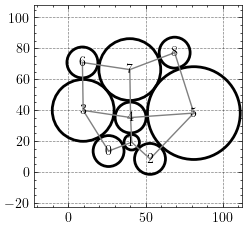

In [ ]:
import numpy as np
from scipy.optimize import least_squares
import networkx as nx
import matplotlib.pyplot as plt

def _seg_seg_dist(p1, p2, q1, q2):
    """
    Shortest distance between segments p1–p2 and q1–q2 in ℝ².
    """
    u = p2 - p1
    v = q2 - q1
    w = p1 - q1
    a, b, c = u.dot(u), u.dot(v), v.dot(v)
    d, e     = u.dot(w), v.dot(w)
    D = a*c - b*b
    if D < 1e-8:  # parallel or nearly
        s = 0.0
        t = e/c if c>1e-8 else 0.0
    else:
        s = ( b*e - c*d)/D
        t = ( a*e - b*d)/D
    s = np.clip(s, 0.0, 1.0)
    t = np.clip(t, 0.0, 1.0)
    cp1 = p1 + s*u
    cp2 = q1 + t*v
    return np.linalg.norm(cp1-cp2)

def pack_down(adj_array, radii,
                   w_neigh=1.0,
                   w_ov=10.0,
                   w_plan=1e5,
                   margin=0.0):
    adj   = np.asarray(adj_array)
    radii = np.asarray(radii)
    N     = len(radii)

    # build neighbor list & edges
    neigh_lists = [np.unique(adj[i][adj[i]>=0].astype(int)) for i in range(N)]
    edges = [(i,j) for i in range(N) for j in neigh_lists[i] if j>i]

    # compute grid‐spacing D and initial grid
    min_neigh = np.array([radii[i]+radii[j]+1 for i,j in edges])
    D = min_neigh.max()
    L = int(np.round(np.sqrt(N)))
    grid_xy = np.column_stack((np.arange(N)%L, np.arange(N)//L))
    x0 = (grid_xy * D).ravel()

    # all‐pairs for non‐overlap
    all_pairs = [(i,j) for i in range(N) for j in range(i+1,N)]
    # edge‐pairs for planarity
    edge_pairs = []
    for a,b in edges:
        for c,d in edges:
            if a<b and c<d and {a,b}.isdisjoint({c,d}):
                if (c,d,a,b) not in edge_pairs:
                    edge_pairs.append((a,b,c,d))

    def residuals(x):
        X = x.reshape(N,2)
        res = []

        # 1) **spring** pull on neighbors: drive d → (r_i + r_j + 1)
        for k,(i,j) in enumerate(edges):
            d = np.linalg.norm(X[i]-X[j])
            res.append(w_neigh * (d - min_neigh[k]))

        # 2) non‐overlap hinge
        for i,j in all_pairs:
            d = np.linalg.norm(X[i]-X[j])
            pen = max(0.0, (radii[i]+radii[j]) - d)
            res.append(w_ov * pen)

        # 3) planarity hinge
        for i,j,k,l in edge_pairs:
            dseg = _seg_seg_dist(X[i],X[j], X[k],X[l])
            pen = max(0.0, margin - dseg)
            res.append(w_plan * pen)

        return np.array(res)

    sol = least_squares(residuals, x0, method='trf', verbose=1)
    return sol.x.reshape(N,2)

def draw(coords, radii, adj_array):
    G = nx.Graph()
    N = len(radii)
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in adj_array[i][adj_array[i]>=0].astype(int):
            if i<j: G.add_edge(i,j)

    pos = {i:tuple(coords[i]) for i in range(N)}
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # edges
    for u,v in G.edges():
        x0,y0 = coords[u]
        x1,y1 = coords[v]
        ax.plot([x0,x1],[y0,y1],'gray')

    # circles
    for i in range(N):
        circ = plt.Circle(pos[i], radii[i], fill=False, lw=2)
        ax.add_patch(circ)
        ax.text(*pos[i], str(i), ha='center', va='center')

    mn = coords.min(axis=0) - radii.max() - 1
    mx = coords.max(axis=0) + radii.max() + 1
    ax.set_xlim(mn[0], mx[0])
    ax.set_ylim(mn[1], mx[1])
    plt.show()

if __name__ == '__main__':
    adj = np.array([
      [1,1,3,-100,-100,-100],
      [-100,0,2,4,-100,-100],
      [2,1,5,-100,-100,-100],
      [-100,0,4,6,-100,-100],
      [-100,1,3,5,7,-100],
      [-100,2,4,8,-100,-100],
      [3,3,7,-100,-100,-100],
      [-100,4,6,8,-100,-100],
      [4,5,7,-100,-100,-100],
    ])
    radii = np.array([10.,5.,10.,20.,10.,30.,10.,20.,10.])

    coords = pack_down(adj, radii,
                       w_neigh=1.0,
                       w_ov=10.0,
                       w_plan=1e5,
                       margin=0.0)
    draw(coords, radii, adj)


`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 1.2375e+03, final cost 1.0730e-13, first-order optimality 3.32e-06.


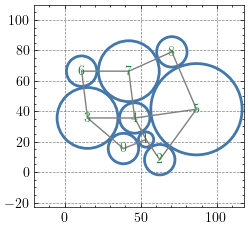

In [99]:
def _seg_seg_dist(p1, p2, q1, q2):
    """
    Compute shortest distance between segments p1–p2 and q1–q2 in 2D.
    """
    u = p2 - p1
    v = q2 - q1
    w = p1 - q1
    a = u.dot(u); b = u.dot(v); c = v.dot(v)
    d = u.dot(w); e = v.dot(w)
    D = a*c - b*b
    if D < 1e-8:  # nearly parallel
        s = 0.0
        t = e / c if c > 1e-8 else 0.0
    else:
        s = ( b*e - c*d) / D
        t = ( a*e - b*d) / D
    s = np.clip(s, 0.0, 1.0)
    t = np.clip(t, 0.0, 1.0)
    cp1 = p1 + s*u
    cp2 = q1 + t*v
    return np.linalg.norm(cp1 - cp2)

def pack_down_pull_min_all(adj_array, radii,
                           w_neigh=1.0,
                           w_minsep=10.0,
                           w_planar=1e5,
                           margin=0.0,
                           s_min=1.0):
    """
    Embed circles ensuring:
      - neighbor pairs are pulled to center-dist = r_i + r_j + 1
      - ALL pairs (connected or not) maintain center-dist >= r_i + r_j + 1
      - planarity: no edge crossings (segment-dist >= margin)
    """
    adj   = np.asarray(adj_array)
    radii = np.asarray(radii)
    N     = len(radii)

    # build neighbor list & undirected edges
    neigh_lists = [np.unique(adj[i][adj[i]>=0].astype(int)) for i in range(N)]
    edges = [(i, j) for i in range(N) for j in neigh_lists[i] if j > i]

    # compute uniform grid spacing D
    min_neigh = np.array([radii[i] + radii[j] + s_min for i, j in edges])
    D = min_neigh.max()

    # initial grid layout (N must be a perfect square)
    L = int(np.round(np.sqrt(N)))
    if L * L != N:
        raise ValueError("N is not a perfect square; provide custom init coords")
    grid_xy = np.column_stack((np.arange(N) % L, np.arange(N) // L))
    x0 = (grid_xy * D).ravel()

    # all pairs for global minimum separation
    all_pairs = [(i, j) for i in range(N) for j in range(i+1, N)]

    # edge-pairs for planarity test
    edge_pairs = []
    for a, b in edges:
        for c, d in edges:
            if a < b and c < d and {a, b}.isdisjoint({c, d}):
                if (c, d, a, b) not in edge_pairs:
                    edge_pairs.append((a, b, c, d))

    # precompute minimum center distances
    min_all = { (i, j): radii[i] + radii[j] + s_min for (i, j) in all_pairs }

    def residuals(x):
        X = x.reshape(N, 2)
        res = []

        # 1) neighbor-spring: drive d -> min_all
        for (i, j) in edges:
            d = np.linalg.norm(X[i] - X[j])
            res.append(w_neigh * (d - min_all[(i, j)]))

        # 2) global min-separation hinge
        for (i, j) in all_pairs:
            d = np.linalg.norm(X[i] - X[j])
            pen = max(0.0, min_all[(i, j)] - d)
            res.append(w_minsep * pen)

        # 3) planarity hinge
        for (i, j, k, l) in edge_pairs:
            dseg = _seg_seg_dist(X[i], X[j], X[k], X[l])
            pen = max(0.0, margin - dseg)
            res.append(w_planar * pen)

        return np.array(res)

    sol = least_squares(residuals, x0, method='trf', verbose=1)
    return sol.x.reshape(N, 2)

def plot_circles(coords, radii, adj_array, s_min=1):
    """Draw circles and edges using NetworkX + Matplotlib."""
    N = len(radii)
    G = nx.Graph()
    G.add_nodes_from(range(N))
    adj = np.asarray(adj_array)
    for i in range(N):
        for j in adj[i][adj[i] >= 0].astype(int):
            if i < j:
                G.add_edge(i, j)

    pos = {i: tuple(coords[i]) for i in range(N)}
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # draw edges
    for u, v in G.edges():
        x0, y0 = coords[u]
        x1, y1 = coords[v]
        ax.plot([x0, x1], [y0, y1], 'gray', lw=1)

    # draw circles and labels
    for i in range(N):
        circ = plt.Circle(pos[i], radii[i], fill=False, edgecolor='C0', lw=2)
        ax.add_patch(circ)
        ax.text(pos[i][0], pos[i][1], str(i), ha='center', va='center', color='C2')

    # autoscale
    xs = coords[:, 0]; ys = coords[:, 1]
    pad = radii.max() + s_min
    ax.set_xlim(xs.min() - pad, xs.max() + pad)
    ax.set_ylim(ys.min() - pad, ys.max() + pad)
    plt.show()

# Example usage
if __name__ == '__main__':
    adj = np.array([
        [1, 1, 3, -100, -100, -100],
        [-100, 0, 2, 4, -100, -100],
        [2, 1, 5, -100, -100, -100],
        [-100, 0, 4, 6, -100, -100],
        [-100, 1, 3, 5, 7, -100],
        [-100, 2, 4, 8, -100, -100],
        [3, 3, 7, -100, -100, -100],
        [-100, 4, 6, 8, -100, -100],
        [4, 5, 7, -100, -100, -100],
    ])
    radii = np.array([10., 5., 10., 20., 10., 30., 10., 20., 10.])

    coords = pack_down_pull_min_all(adj, radii,
                                    w_neigh=1.0,
                                    w_minsep=10.0,
                                    w_planar=1e5,
                                    margin=0.0,s_min=1)
    plot_circles(coords, radii, adj, s_min=1)

In [17]:
distances

array([[0.        , 1.        , 2.        , 1.        , 1.41421356,
        2.23606798, 2.        , 2.23606798, 2.82842712],
       [1.        , 0.        , 1.        , 1.41421356, 1.        ,
        1.41421356, 2.23606798, 2.        , 2.23606798],
       [2.        , 1.        , 0.        , 2.23606798, 1.41421356,
        1.        , 2.82842712, 2.23606798, 2.        ],
       [1.        , 1.41421356, 2.23606798, 0.        , 1.        ,
        2.        , 1.        , 1.41421356, 2.23606798],
       [1.41421356, 1.        , 1.41421356, 1.        , 0.        ,
        1.        , 1.41421356, 1.        , 1.41421356],
       [2.23606798, 1.41421356, 1.        , 2.        , 1.        ,
        0.        , 2.23606798, 1.41421356, 1.        ],
       [2.        , 2.23606798, 2.82842712, 1.        , 1.41421356,
        2.23606798, 0.        , 1.        , 2.        ],
       [2.23606798, 2.        , 2.23606798, 1.41421356, 1.        ,
        1.41421356, 1.        , 0.        , 1.        ],


In [18]:
sim_class.radius_vals

array([10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [15]:
distances = np.zeros((sim_class.N_particles,sim_class.N_particles))

for i in range(sim_class.N_particles):
    for j in range(sim_class.N_particles):
        x_i = sim_class.pos[i][0]
        y_i = sim_class.pos[i][1]
        x_j = sim_class.pos[j][0]
        y_j = sim_class.pos[j][1]
        d   = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2)
        
        distances[i,j] = d

for i in range(-1,-sim_class.N_electrodes-1,-1):
    pass

In [6]:
sim_class.pos

{0: [0, 0],
 1: [1, 0],
 2: [2, 0],
 3: [0, 1],
 4: [1, 1],
 5: [2, 1],
 6: [0, 2],
 7: [1, 2],
 8: [2, 2],
 np.int64(-1): (-1, 0),
 np.int64(-2): (3, 0),
 np.int64(-3): (-1, 2),
 np.int64(-4): (3, 2)}

In [19]:
sim_class.net_topology

array([[   1,    1,    3, -100, -100, -100],
       [-100,    0,    2,    4, -100, -100],
       [   2,    1,    5, -100, -100, -100],
       [-100,    0,    4,    6, -100, -100],
       [-100,    1,    3,    5,    7, -100],
       [-100,    2,    4,    8, -100, -100],
       [   3,    3,    7, -100, -100, -100],
       [-100,    4,    6,    8, -100, -100],
       [   4,    5,    7, -100, -100, -100]])

In [42]:
EPSILON_0 = 8.85418781762039e-3

In [43]:
def cap_m_old(eps_r, r1, r2, s=1.0):
    # Base factor
    d       = r1 + r2 + s
    factor  = 4 * np.pi * EPSILON_0 * eps_r * (r1 * r2) / d
    
    # Terms of the Taylor expansion
    term1       = 1.0
    term2       = (r1 * r2) / (d**2 - 2*r1*r2)
    denominator = d**4 - 4*(d**2)*r1*r2 + 3*(r1**2)*(r2**2)
    term3       = ((r1**2)*(r2**2)) / denominator
    cap         = factor * (term1 + term2 + term3)
                    
    return cap

def cap_m_sinh(eps_r, r1, r2, s=1.0, N=20):
    
    d       = r1 + r2 + s
    U       = np.arccosh((d**2 - r1**2 - r2**2)/(2*r1*r2))
    factor  = 4 * np.pi * EPSILON_0 * eps_r * (r1 * r2) / d
    sums    = []

    for n in range(1,N+1):
        sums.append(1/np.sinh(n*U))

    cap = factor*np.sinh(U)*np.sum(sums)

    return cap

In [44]:
r1      = 10.0
r2      = 10.0
eps_r   = 2.6
C12_o   = cap_m_old(eps_r, r1, r2)

In [45]:
N_vals      = np.arange(1,20)
c12_n_vals  = []
for N in N_vals:
    c12_n_vals.append(cap_m_sinh(eps_r,r1,r2,N=N))

Text(0.5, 0, '$N$')

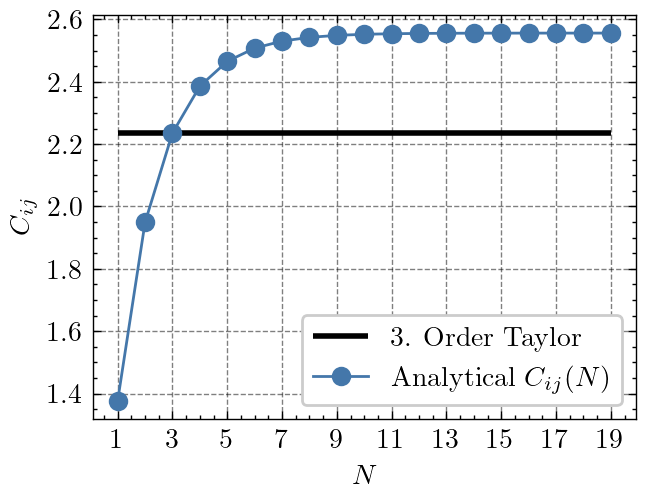

In [46]:
fig, ax = plt.subplots(dpi=200)
ax.hlines(C12_o, xmin=np.min(N_vals), xmax=np.max(N_vals), lw=2, colors='black', label='3. Order Taylor')
ax.plot(N_vals, c12_n_vals, '-o', label='Analytical $C_{ij}(N)$')
ax.legend()
_ = ax.set_xticks(N_vals[0::2])
ax.set_ylabel("$C_{ij}$")
ax.set_xlabel("$N$")